In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Data from the lab: a Rabi flop

## A bit of lab lingo
Just to set the stage.

- **PMT**: photomultiplier tube, the detector used in the lab to measure the state of the qubit. You can think of it as a photon-counting device, returning a number of counts proportional to the number of photons emitted by the ion by the end of that shot.
- **shot**: a single realization of the experimental pulse sequence. The outcome of a shot is the measured state of the qubit at the end of the sequence, represented by the number of counts returned by the PMT.
  - a high number of counts means that the ion was measured in the bright state $|B\rangle$ or $|\downarrow\rangle$
  - a low number means that the ion was mesaured in the dark state $|D\rangle$ or $|\uparrow\rangle$
- **experiment**: a repetition of shots, all run with exactly the same parameters. The outcome of an experiment is the probability of measuring the ion in the bright state $P_B$, estimated from the distribution of counts from all the shots.
- **scan**: a sequence of experiments with one or more varying parameters. The outcome of a scan is the whole measurement of $P_B$ as a function of the scanned parameters, from which usually we can infer other quantities or properties of the system.

In this case, our Rabi flop data is a scan of the laser pulse time $t$. Analysing $P_B$ as a function of the pulse time we can extract e.g. the Rabi frequncy, or equivalently the pi time $t_\pi$.

## Data structure
Every row of the CSV file correspond to an experiment

Columns of the CSV file:

- Index: just a label for the experiment
- x0: the scanned variable. In this case, the time of the pulse in microseconds
- n_shots: the number of shots N in the experiment
- all other columns, from c1 to cN, reports the PMT counts in the shot N

Here we have the same number of shots for all experiments, which is not necessary but simplifies tha data structure a bit (so all rows have the same length in the table). For M experiments with N shots each, the scan data in this format is a table with M rows and N + 3 columns.


In [2]:
data_root = Path("../data")
data_file = data_root / "06_rabi_flop_pmt_counts.csv"

A = np.loadtxt(data_file, delimiter=",", skiprows=1)
A

array([[ 0.        ,  1.4       , 50.        , ..., 61.        ,
        52.        , 41.        ],
       [ 1.        ,  1.98367347, 50.        , ..., 58.        ,
        47.        , 63.        ],
       [ 2.        ,  2.56734694, 50.        , ..., 58.        ,
         3.        , 11.        ],
       ...,
       [47.        , 28.83265306, 50.        , ...,  8.        ,
        61.        , 11.        ],
       [48.        , 29.41632653, 50.        , ...,  6.        ,
         9.        , 10.        ],
       [49.        , 30.        , 50.        , ..., 11.        ,
         7.        ,  4.        ]])

In [3]:
# Bonus: Load data with pandas, just for ease of visualization

D = pd.read_csv(data_file)
D.head()

,exp_index,x0,n_shots,c1,c2,c3,c4,c5,c6,c7,...,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50
0,0,1.400000,50,46,56,48,49,61,58,52,...,52,60,46,55,61,67,58,61,52,41
1,1,1.983673,50,52,10,60,63,56,63,9,...,62,68,60,52,52,4,4,58,47,63
2,2,2.567347,50,56,72,8,54,46,3,6,...,3,4,5,44,9,52,6,58,3,11
3,3,3.151020,50,56,10,56,44,7,4,42,...,72,8,9,55,7,52,68,7,51,7
4,4,3.734694,50,8,10,66,8,5,8,8,...,7,53,7,63,8,6,6,50,6,11


In [4]:
t = A[:, 1]
pmt_counts = A[:, 3:]
pmt_counts.shape

(50, 50)

## Distribution of PMT counts
Let's plot a histogram of the PMT counts for some of the experiments. 50 shots is not much though...

In all experiments of this scan, all detection events have the same parameters: intensity of the detection beam, detection time etc... So in all shots the measured counts will come from the same distribution, which only depends on the state of the ion (B/D). We can collect the counts from all shots together to get better statistics

Text(0.5, 1.0, 'All experiments')

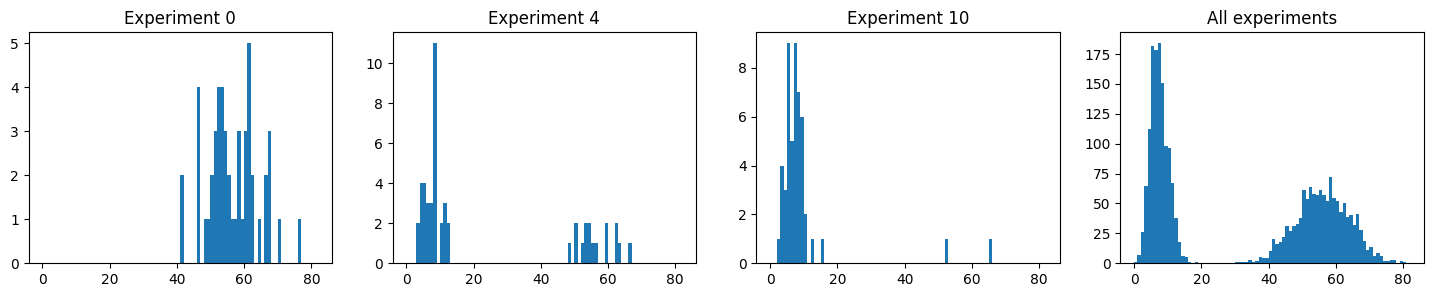

In [5]:
plot_from_experiment = [0, 4, 10]


fig, axes = plt.subplots(1, len(plot_from_experiment) + 1, figsize=(18, 3), sharex=True)
bins = np.arange(0, pmt_counts.max())

for j, index in enumerate(plot_from_experiment):
    ax = axes[j]
    ax.hist(pmt_counts[index], bins=bins, color="C0")
    ax.set_title(f"Experiment {index}")

axes[-1].hist(pmt_counts.ravel(), bins=bins, color="C0");
axes[-1].set_title("All experiments")

## Thresholding

Counts are split in two (Poissonian) distributions, one with high values and one with low values.

Let's set a reasonable threshold and claim that everytime the counts are above threshold the ion was bright

(-0.5, 83.5)

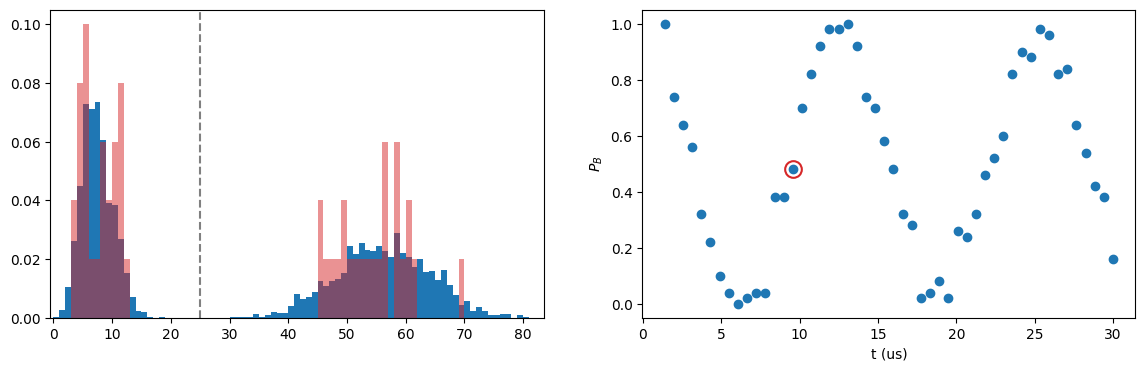

In [6]:
threshold = 25  # try to set it to a clearly wrong value

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 4))

# plot again - density=True normalizes the histogram such that the integral is 1
ax0.hist(pmt_counts.ravel(), bins=bins, color="C0", density=True)
ax0.axvline(threshold, color="gray", linestyle="--")

# calculate P_B
p_bright = np.mean(pmt_counts > threshold, axis=1)

ax1.plot(t, p_bright, "o")  # beautiful Rabi flop
ax1.set(ylim=(-0.05, 1.05), xlabel="t (us)", ylabel="$P_B$")

index = 14
ax1.plot(t[index], p_bright[index], "C3o", markersize=12, mfc="none", mew=1.5)
ax0.hist(pmt_counts[index, :], bins=bins, color="C3", density=True, alpha=0.5, label="Experiment 14")
ax0.set_xlim(-0.5, np.max(pmt_counts) + 0.5)

## Fit the Rabi frequency
Assume that the flop is resonant

[[Model]]
    Model(resonant_rabi_flop)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 50
    # variables        = 1
    chi-square         = 0.17958058
    reduced chi-square = 0.00366491
    Akaike info crit   = -279.457714
    Bayesian info crit = -277.545691
    R-squared          = 0.96661098
[[Variables]]
    Omega:  0.49707199 +/- 0.00129856 (0.26%) (init = 0.5)
    t_pi:   6.32019644 +/- 0.01651096 (0.26%) == 'pi/Omega'


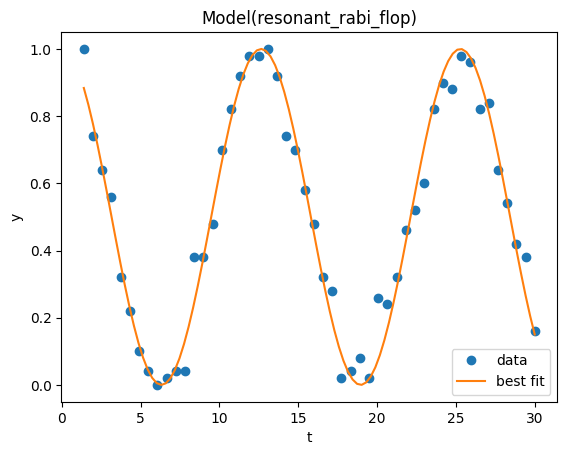

In [7]:
# learn how to use this fitting library, I personally love it
from lmfit import Model


def resonant_rabi_flop(t, Omega):
    return 0.5 * (1 + np.cos(Omega * t))


M = Model(resonant_rabi_flop)
M.set_param_hint("t_pi", expr="pi/Omega")
p0 = M.make_params(Omega=0.5)

res = M.fit(p_bright, p0, t=t)
res.plot_fit(numpoints=100)

print(res.fit_report())